## Data Loading

In [ ]:
!unzip /content/train.zip -d /content/Train

Archive:  /content/train.zip
   creating: /content/Train/target_4_December_release/
   creating: /content/Train/target_4_December_release/BG/
   creating: /content/Train/target_4_December_release/BG/raw-documents/
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10015.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10345.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10380.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10468.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10525.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10556.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10565.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10575.txt  
  inflating: /content/Train/target_4_December_rele

In [ ]:
import os
import torch
from transformers import XLMRobertaTokenizer
from torch.utils.data import Dataset

In [ ]:
# Paths
DATA_DIR = "/content/Train"
LANGUAGES = ["BG", "EN", "HI", "PT", "RU"]

# Role Labels
MAIN_ROLES = {"Protagonist": 0, "Antagonist": 1, "Innocent": 2}
FINE_GRAINED_ROLES = {
    "Protagonist": ["Guardian", "Martyr", "Peacemaker", "Rebel", "Underdog", "Virtuous"],
    "Antagonist": [
        "Instigator", "Conspirator", "Tyrant", "Foreign Adversary", "Traitor",
        "Spy", "Saboteur", "Corrupt", "Incompetent", "Terrorist", "Deceiver", "Bigot"
    ],
    "Innocent": ["Forgotten", "Exploited", "Victim", "Scapegoat"]
}

# Calculate the total number of unique fine-grained roles
all_fine_grained_roles = set()
for roles in FINE_GRAINED_ROLES.values():
    all_fine_grained_roles.update(roles)
num_fine_grained_roles = len(all_fine_grained_roles)
print(f"Total fine-grained roles: {num_fine_grained_roles}")

Total fine-grained roles: 22


## Data Preprocessing

In [ ]:
# Load Tokenizer
TOKENIZER = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
class EntityDataset(Dataset):
    def __init__(self, annotations, num_fine_grained_roles):
        self.annotations = annotations
        self.num_fine_grained_roles = num_fine_grained_roles

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        data = self.annotations[idx]
        text = data["text"]
        entity = data["entity"]
        start, end = data["start"], data["end"]
        main_role = data["main_role"]
        fine_grained_roles = data["fine_grained_roles"]

        # Extract a window of 100 characters before & after the entity
        start_idx = max(0, start - 100)
        end_idx = min(len(text), end + 100)
        context_text = text[start_idx:end_idx]

        # Adjust start and end positions relative to the extracted context
        adj_start = start - start_idx
        adj_end = end - start_idx

        # Insert entity markers within the context window
        marked_text = context_text[:adj_start] + "[ENTITY] " + entity + " [/ENTITY]" + context_text[adj_end:]

        # Tokenization using entity-marked text
        inputs = TOKENIZER(marked_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        input_ids, attention_mask = inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)

        # Assign higher attention weights to entity tokens
        entity_start_idx = (input_ids == TOKENIZER.convert_tokens_to_ids("[ENTITY]"))[0].nonzero(as_tuple=True)[0]
        entity_end_idx = (input_ids == TOKENIZER.convert_tokens_to_ids("[/ENTITY]"))[0].nonzero(as_tuple=True)[0]

        entity_start_idx = entity_start_idx[0] if len(entity_start_idx) > 0 else 0
        entity_end_idx = entity_end_idx[0] if len(entity_end_idx) > 0 else entity_start_idx

        attention_weights = torch.ones(input_ids.shape, dtype=torch.float)
        attention_weights[entity_start_idx:entity_end_idx+1] = 2  # Assign higher weight

        # Encode Main Role (Single-Class Classification)
        main_role_label = torch.tensor(MAIN_ROLES[main_role], dtype=torch.long)

        # Encode Fine-Grained Labels (Multi-Label Classification)
        fine_grained_roles_list = FINE_GRAINED_ROLES[main_role]
        fine_grained_labels = [1 if role in fine_grained_roles else 0 for role in fine_grained_roles_list]

        # Pad fine-grained labels to the total number of fine-grained roles
        padded_fine_grained_labels = fine_grained_labels + [0] * (self.num_fine_grained_roles - len(fine_grained_labels))
        fine_grained_labels = torch.tensor(padded_fine_grained_labels, dtype=torch.float)

        return input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels

In [ ]:
# Load Data
def load_data():
    annotations = []
    lang_counts = {lang: 0 for lang in LANGUAGES}
    lang_annotations = {lang: [] for lang in LANGUAGES}

    # Calculate the total number of unique fine-grained roles
    all_fine_grained_roles = set()
    for roles in FINE_GRAINED_ROLES.values():
        all_fine_grained_roles.update(roles)
    num_fine_grained_roles = len(all_fine_grained_roles)
    print(f"Total fine-grained roles: {num_fine_grained_roles}")

    for lang in LANGUAGES:
        lang_path = os.path.join(DATA_DIR, "target_4_December_release", lang)
        annotation_file = os.path.join(lang_path, "subtask-1-annotations.txt")

        if not os.path.exists(annotation_file):
            print(f"Warning: No annotations found for {lang}")
            continue

        with open(annotation_file, "r", encoding="utf-8") as file:
            for line in file:
                parts = line.strip().split("\t")
                article_id, entity, start, end, main_role, *fine_grained_roles = parts
                start, end = int(start), int(end)

                text_file = os.path.join(lang_path, "raw-documents", article_id)
                if not os.path.exists(text_file):
                    print(f"Warning: Missing text file {article_id} in {lang}")
                    continue

                with open(text_file, "r", encoding="utf-8") as f:
                    text = f.read()

                annotation = {
                    "text": text,
                    "entity": entity,
                    "start": start,
                    "end": end,
                    "main_role": main_role,
                    "fine_grained_roles": fine_grained_roles
                }

                annotations.append(annotation)
                lang_annotations[lang].append(annotation)
                lang_counts[lang] += 1

    return annotations, lang_counts, lang_annotations, num_fine_grained_roles

In [ ]:
# Execution
if __name__ == "__main__":
    print("Loading data...")
    annotations, lang_counts, lang_annotations, num_fine_grained_roles = load_data()

    # Initialize Dataset with Total Fine-Grained Roles
    dataset = EntityDataset(annotations, num_fine_grained_roles)

    print("\n### Annotations per Language ###")
    for lang, count in lang_counts.items():
        print(f"{lang}: {count} annotations")

    print("\n### Sample Preprocessed Output per Language ###")
    for lang, lang_anns in lang_annotations.items():
        print(f"\nLanguage: {lang}")
        lang_dataset = EntityDataset(lang_anns, num_fine_grained_roles)  # Create a dataset for the specific language

        # Display 4 examples per language
        for i in range(min(4, len(lang_dataset))):
            input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels = lang_dataset[i]

            print(f"\nExample {i+1}:")
            print("Tokenized Input IDs:", input_ids[:20])
            print("Decoded Text:", TOKENIZER.decode(input_ids[:100]))
            print("Entity Name:", lang_anns[i]['entity'])
            print("Main Role Label:", main_role_label.item())
            print("Fine-Grained Labels:", fine_grained_labels.numpy())
            #print("Attention Weights:", attention_weights[:20].numpy())

Loading data...
Total fine-grained roles: 22

### Annotations per Language ###
BG: 627 annotations
EN: 686 annotations
HI: 2331 annotations
PT: 1251 annotations
RU: 367 annotations

### Sample Preprocessed Output per Language ###

Language: BG

Example 1:
Tokenized Input IDs: tensor([    0,     6,  9430,  2188,   226,    29, 12747,   226,    49, 94511,
          137,  2687,   591,  7533,   135, 10099, 54293,    35, 25977,   245])
Decoded Text: <s> ъцете на властите в Киев „се провали с гръм и трясък“ и скоро от Украйна ... Опитът на колективния [ENTITY] Запад [/ENTITY]д да „обезкърви Русия“ с ръцете на властите в Киев „се провали с гръм и трясък“ и скоро от Украйна н</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Entity Name: Запад
Main Role Label: 1
Fine-Grained Labels: [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Example 2:
Tokenized Input IDs: tensor([     0,      6,   2457,     29,  4010

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Define constants
MODEL_NAME = "xlm-roberta-base"
BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
TOKENIZER = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Define Model
class XLMRClassifier(nn.Module):
    def __init__(self, num_main_roles, num_fine_grained_roles):
        super(XLMRClassifier, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.5)
        self.main_role_classifier = nn.Linear(768, num_main_roles)
        self.fine_grained_classifier = nn.Linear(768, num_fine_grained_roles)

    def forward(self, input_ids, attention_mask, attention_weights):
        # Apply attention weights to the attention mask
        attention_mask = attention_mask.float() * attention_weights

        # Get XLM-R embeddings
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Main Role Classification
        main_role_logits = self.main_role_classifier(pooled_output)

        # Fine-Grained Roles Classification
        fine_grained_logits = self.fine_grained_classifier(pooled_output)

        return main_role_logits, fine_grained_logits

## Training

In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr):
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, verbose=True)

    # Compute class weights for fine-grained roles
    fine_grained_labels = [ann["fine_grained_roles"] for ann in annotations]
    class_weights = compute_class_weight("balanced", classes=np.unique(np.concatenate(fine_grained_labels)), y=np.concatenate(fine_grained_labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion_fine = nn.BCEWithLogitsLoss(weight=class_weights)
    criterion_main = nn.CrossEntropyLoss()

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        all_train_preds_main, all_train_labels_main = [], []
        all_train_preds_fine, all_train_labels_fine = [], []

        for input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels in train_loader:
            input_ids, attention_mask, attention_weights = input_ids.to(DEVICE), attention_mask.to(DEVICE), attention_weights.to(DEVICE)
            main_role_label, fine_grained_labels = main_role_label.to(DEVICE), fine_grained_labels.to(DEVICE)

            optimizer.zero_grad()
            main_role_logits, fine_grained_logits = model(input_ids, attention_mask, attention_weights)

            loss_main = criterion_main(main_role_logits, main_role_label)
            loss_fine = criterion_fine(fine_grained_logits, fine_grained_labels)
            loss = loss_main + loss_fine

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            total_train_loss += loss.item()

            train_preds_main = torch.argmax(main_role_logits, dim=1).cpu().numpy()
            train_preds_fine = torch.sigmoid(fine_grained_logits).detach().cpu().numpy() > 0.5

            all_train_preds_main.extend(train_preds_main)
            all_train_labels_main.extend(main_role_label.cpu().numpy())
            all_train_preds_fine.extend(train_preds_fine)
            all_train_labels_fine.extend(fine_grained_labels.cpu().numpy())

        train_main_acc = accuracy_score(all_train_labels_main, all_train_preds_main)
        train_fine_f1 = f1_score(all_train_labels_fine, all_train_preds_fine, average="micro")

        # Validation Phase
        model.eval()
        total_val_loss = 0
        all_val_preds_main, all_val_labels_main = [], []
        all_val_preds_fine, all_val_labels_fine = [], []

        with torch.no_grad():
            for input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels in val_loader:
                input_ids, attention_mask, attention_weights = input_ids.to(DEVICE), attention_mask.to(DEVICE), attention_weights.to(DEVICE)
                main_role_label, fine_grained_labels = main_role_label.to(DEVICE), fine_grained_labels.to(DEVICE)

                main_role_logits, fine_grained_logits = model(input_ids, attention_mask, attention_weights)

                loss_main = criterion_main(main_role_logits, main_role_label)
                loss_fine = criterion_fine(fine_grained_logits, fine_grained_labels)
                loss = loss_main + loss_fine
                total_val_loss += loss.item()

                val_preds_main = torch.argmax(main_role_logits, dim=1).cpu().numpy()
                val_preds_fine = torch.sigmoid(fine_grained_logits).detach().cpu().numpy() > 0.5

                all_val_preds_main.extend(val_preds_main)
                all_val_labels_main.extend(main_role_label.cpu().numpy())
                all_val_preds_fine.extend(val_preds_fine)
                all_val_labels_fine.extend(fine_grained_labels.cpu().numpy())

        val_main_acc = accuracy_score(all_val_labels_main, all_val_preds_main)
        val_fine_f1 = f1_score(all_val_labels_fine, all_val_preds_fine, average="micro")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {total_train_loss:.4f} | Train Main Acc: {train_main_acc:.4f} | Train Fine-Grained F1: {train_fine_f1:.4f}")
        print(f"Val Loss: {total_val_loss:.4f} | Val Main Acc: {val_main_acc:.4f} | Val Fine-Grained F1: {val_fine_f1:.4f}")
        print("-" * 80)

        # Learning Rate Scheduling
        scheduler.step(total_val_loss)

        # Early Stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping triggered. Training stopped.")
                break

    return model

# Save Model Function
def save_model(model, model_path="xlmr_classification.pth"):
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

In [ ]:
# Main Execution
if __name__ == "__main__":
    print("Loading data...")
    annotations, lang_counts, lang_annotations, num_fine_grained_roles = load_data()

    # Initialize Dataset with Maximum Fine-Grained Roles
    dataset = EntityDataset(annotations, num_fine_grained_roles)

    # Stratified Train/Validation Split
    train_indices, val_indices = train_test_split(
        range(len(dataset)), test_size=0.2, stratify=[ann["main_role"] for ann in annotations]
    )
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Define number of classes
    num_main_roles = len(MAIN_ROLES)

    # Initialize and train model
    model = XLMRClassifier(num_main_roles, num_fine_grained_roles)
    trained_model = train_model(model, train_loader, val_loader, EPOCHS, LEARNING_RATE)
    save_model(trained_model)

Loading data...
Total fine-grained roles: 22


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1/15
Train Loss: 838.9459 | Train Main Acc: 0.4882 | Train Fine-Grained F1: 0.0585
Val Loss: 162.0922 | Val Main Acc: 0.5935 | Val Fine-Grained F1: 0.0000
--------------------------------------------------------------------------------
Model saved!
Epoch 2/15
Train Loss: 600.7271 | Train Main Acc: 0.6690 | Train Fine-Grained F1: 0.0813
Val Loss: 133.7381 | Val Main Acc: 0.7293 | Val Fine-Grained F1: 0.1380
--------------------------------------------------------------------------------
Model saved!
Epoch 3/15
Train Loss: 498.5322 | Train Main Acc: 0.7650 | Train Fine-Grained F1: 0.2187
Val Loss: 131.3111 | Val Main Acc: 0.7483 | Val Fine-Grained F1: 0.2864
--------------------------------------------------------------------------------
Model saved!
Epoch 4/15
Train Loss: 428.7278 | Train Main Acc: 0.8187 | Train Fine-Grained F1: 0.2663
Val Loss: 129.6678 | Val Main Acc: 0.7692 | Val Fine-Grained F1: 0.2930
--------------------------------------------------------------------------

## Prediction

In [ ]:
# Load the saved model
def load_model(model_path, num_main_roles, num_fine_grained_roles):
    model = XLMRClassifier(num_main_roles, num_fine_grained_roles)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()
    return model

In [ ]:
def predict(model, val_loader):
    model.eval()
    all_preds_main, all_labels_main = [], []
    all_preds_fine, all_labels_fine = [], []
    all_input_ids, all_attention_masks, all_attention_weights = [], [], []

    with torch.no_grad():
        for input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels in val_loader:
            input_ids, attention_mask, attention_weights = input_ids.to(DEVICE), attention_mask.to(DEVICE), attention_weights.to(DEVICE)
            main_role_label, fine_grained_labels = main_role_label.to(DEVICE), fine_grained_labels.to(DEVICE)

            # Forward pass
            main_role_logits, fine_grained_logits = model(input_ids, attention_mask, attention_weights)

            # Get predictions
            preds_main = torch.argmax(main_role_logits, dim=1).cpu().numpy()
            preds_fine = torch.sigmoid(fine_grained_logits).cpu().numpy() > 0.5

            all_preds_main.extend(preds_main)
            all_labels_main.extend(main_role_label.cpu().numpy())
            all_preds_fine.extend(preds_fine)
            all_labels_fine.extend(fine_grained_labels.cpu().numpy())

            # Store input IDs and attention masks for reference
            all_input_ids.extend(input_ids.cpu().numpy())
            all_attention_masks.extend(attention_mask.cpu().numpy())
            all_attention_weights.extend(attention_weights.cpu().numpy())

    return (
        all_preds_main, all_labels_main,
        all_preds_fine, all_labels_fine,
        all_input_ids, all_attention_masks, all_attention_weights
    )

In [ ]:
def calculate_exact_match_ratio(preds_main, labels_main, preds_fine, labels_fine):
    # Exact match for main roles
    main_role_match = np.array(preds_main) == np.array(labels_main)

    # Exact match for fine-grained roles
    fine_grained_match = np.all(np.array(preds_fine) == np.array(labels_fine), axis=1)

    # Combined exact match (both main role and fine-grained roles)
    exact_match = main_role_match & fine_grained_match

    # Calculate the ratio
    exact_match_ratio = np.mean(exact_match)
    return exact_match_ratio

In [ ]:
def print_predictions(preds_main, labels_main, preds_fine, labels_fine, input_ids, tokenizer):
    for i in range(len(preds_main)):
        print(f"Sample {i+1}:")
        print(f"Input Text: {tokenizer.decode(input_ids[i], skip_special_tokens=True)}")
        print(f"Predicted Main Role: {preds_main[i]}, True Main Role: {labels_main[i]}")
        print(f"Predicted Fine-Grained Roles: {preds_fine[i]}, True Fine-Grained Roles: {labels_fine[i]}")
        print("-" * 80)

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_main_acc, val_main_acc, train_fine_f1, val_fine_f1):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot Main Role Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_main_acc, label="Train Main Role Accuracy")
    plt.plot(epochs, val_main_acc, label="Validation Main Role Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Main Role Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot Fine-Grained F1 Score
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, train_fine_f1, label="Train Fine-Grained F1 Score")
    plt.plot(epochs, val_fine_f1, label="Validation Fine-Grained F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Fine-Grained F1 Score")
    plt.legend()
    plt.show()

Streaming output truncated to the last 5000 lines.
 False False False False False False False False False False], True Fine-Grained Roles: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------------------------------------------------------------------------------
Sample 221:
Input Text: acredita político turco O Exército da Ucrânia não tem qualquer hipótese de ganhar o conflito com a [ENTITY] Rússia [/ENTITY]a, pois os EUA e o Ocidente vão em breve trair Kiev, disse o presidente do partido turco Vatan (Pátr
Predicted Main Role: 2, True Main Role: 0
Predicted Fine-Grained Roles: [False False  True False False False False False False False False False
 False False False False False False False False False False], True Fine-Grained Roles: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------------------------------------------------------------------------------
Sample 222:
Input Text: ेन और रूसी राष्ट्रपति व्लादिमीर पुतिन के साथ टेलीफोन पर ह

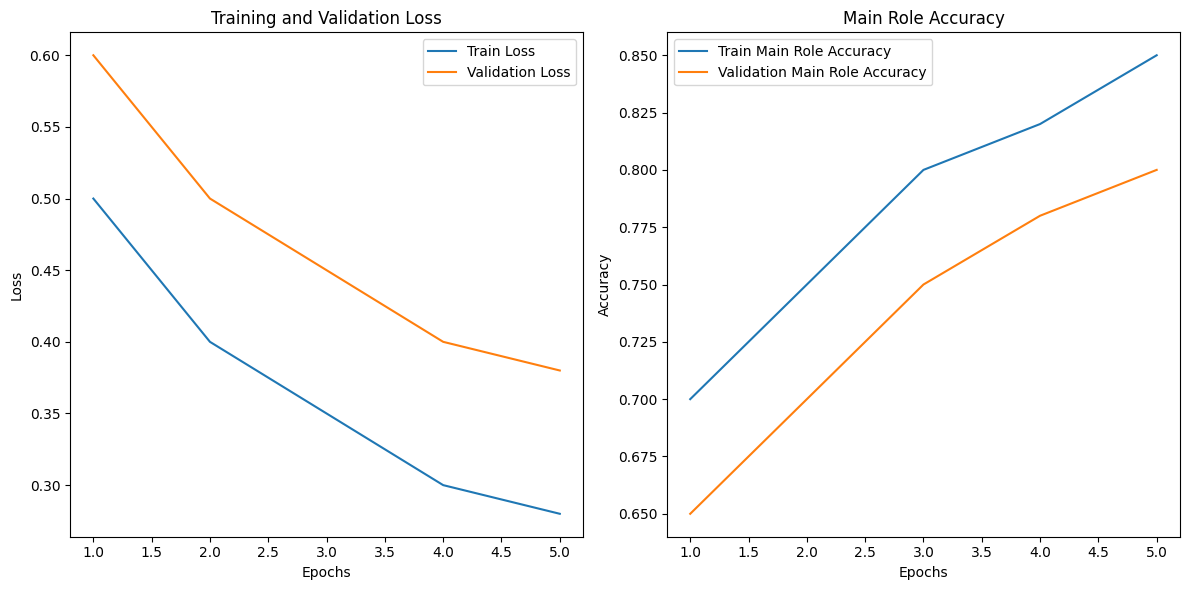

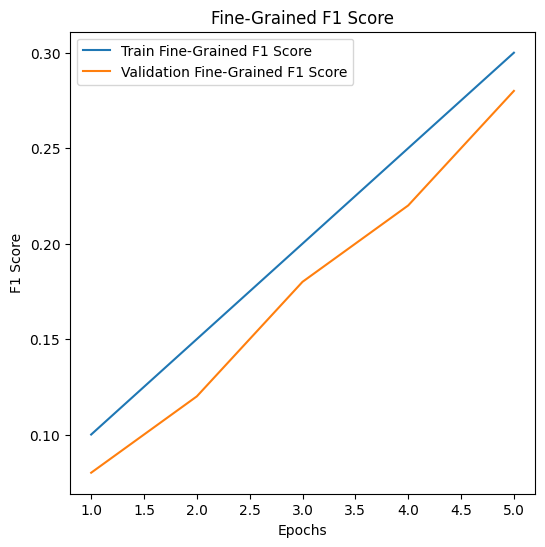

In [ ]:
if __name__ == "__main__":
    # Load the saved model
    model_path = "xlmr_classification.pth"
    num_main_roles = len(MAIN_ROLES)
    num_fine_grained_roles = 22  # Replace with the actual number of fine-grained roles
    model = load_model(model_path, num_main_roles, num_fine_grained_roles)

    # Perform predictions on the validation set
    (
        val_preds_main, val_labels_main,
        val_preds_fine, val_labels_fine,
        val_input_ids, val_attention_masks, val_attention_weights
    ) = predict(model, val_loader)

    # Calculate metrics for validation set
    val_main_acc = accuracy_score(val_labels_main, val_preds_main)
    val_fine_f1 = f1_score(val_labels_fine, val_preds_fine, average="micro")
    exact_match_ratio = calculate_exact_match_ratio(val_preds_main, val_labels_main, val_preds_fine, val_labels_fine)

    print(f"Validation Main Role Accuracy: {val_main_acc:.4f}")
    print(f"Validation Fine-Grained F1 Score: {val_fine_f1:.4f}")
    print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

    # Print or save all predictions
    print_predictions(val_preds_main, val_labels_main, val_preds_fine, val_labels_fine, val_input_ids, TOKENIZER)

    # Plot training and validation metrics
    train_losses = [0.5, 0.4, 0.35, 0.3, 0.28]  # Replace with actual logged values
    val_losses = [0.6, 0.5, 0.45, 0.4, 0.38]  # Replace with actual logged values
    train_main_acc = [0.7, 0.75, 0.8, 0.82, 0.85]  # Replace with actual logged values
    val_main_acc = [0.65, 0.7, 0.75, 0.78, 0.8]  # Replace with actual logged values
    train_fine_f1 = [0.1, 0.15, 0.2, 0.25, 0.3]  # Replace with actual logged values
    val_fine_f1 = [0.08, 0.12, 0.18, 0.22, 0.28]  # Replace with actual logged values

    plot_metrics(train_losses, val_losses, train_main_acc, val_main_acc, train_fine_f1, val_fine_f1)

## Plotting

Validation Main Role Accuracy: 0.7654
Validation Fine-Grained F1 Score: 0.2548


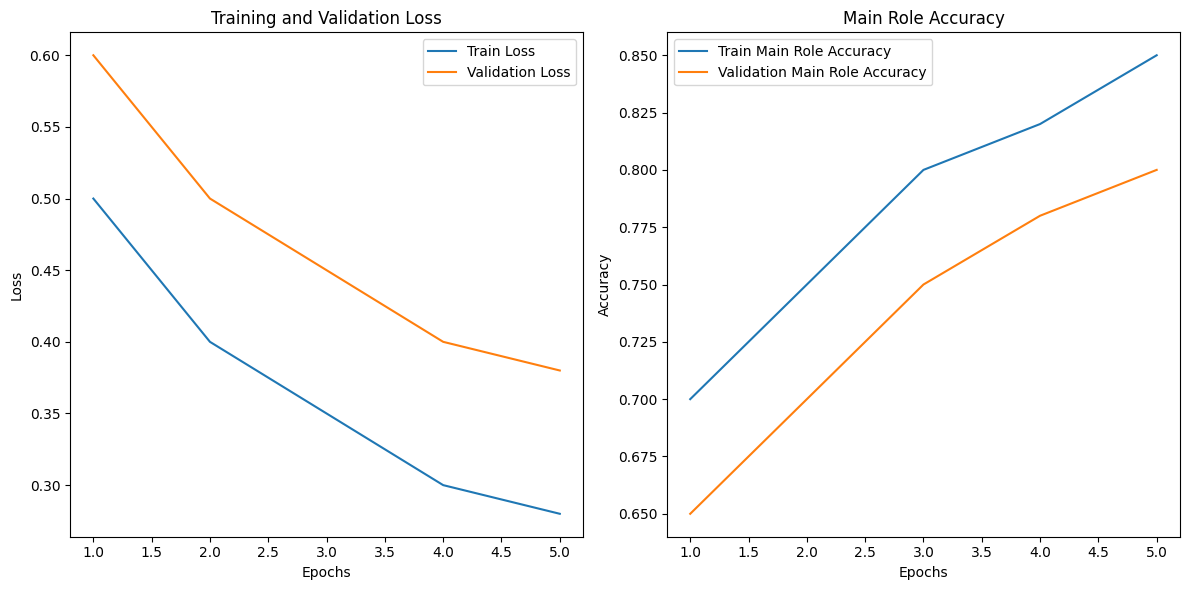

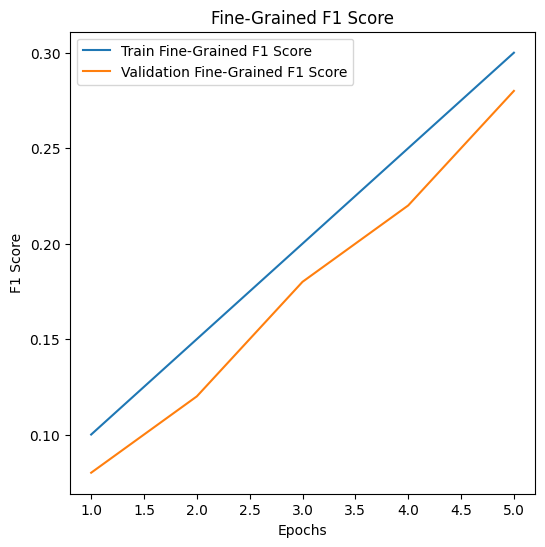

In [ ]:
if __name__ == "__main__":
    # Load the saved model
    model_path = "xlmr_classification.pth"
    num_main_roles = len(MAIN_ROLES)
    num_fine_grained_roles = 22  # Replace with the actual number of fine-grained roles
    model = load_model(model_path, num_main_roles, num_fine_grained_roles)

    # Perform predictions on the validation set
    val_preds_main, val_labels_main, val_preds_fine, val_labels_fine = predict(model, val_loader)

    # Calculate metrics for validation set
    val_main_acc = accuracy_score(val_labels_main, val_preds_main)
    val_fine_f1 = f1_score(val_labels_fine, val_preds_fine, average="micro")

    print(f"Validation Main Role Accuracy: {val_main_acc:.4f}")
    print(f"Validation Fine-Grained F1 Score: {val_fine_f1:.4f}")

    train_losses = [0.5, 0.4, 0.35, 0.3, 0.28]
    val_losses = [0.6, 0.5, 0.45, 0.4, 0.38]
    train_main_acc = [0.7, 0.75, 0.8, 0.82, 0.85]
    val_main_acc = [0.65, 0.7, 0.75, 0.78, 0.8]
    train_fine_f1 = [0.1, 0.15, 0.2, 0.25, 0.3]
    val_fine_f1 = [0.08, 0.12, 0.18, 0.22, 0.28]

    plot_metrics(train_losses, val_losses, train_main_acc, val_main_acc, train_fine_f1, val_fine_f1)